# NLU Homework 4
## Alex Pine (akp258@nyu.edu)
## 2016/11/25

## Problem 1: Data Preparation
I modified Tensorflow's [data_utils.py](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/translate/data_utils.py) code to prepare the Japanese and English sentence pairs for use with the translation code. The code required very few changes to be used with this data set. The only large changes required were to delete the code used for downloading the original dataset, point it to my local data files instead, and modify the language pair from (English, French) to (Japanese, English).

## Problem 2: Simple Encoder-Decoder Model
I modified Tensorflow's [seq2seq_model.py](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/translate/seq2seq_model.py) and [translate.py](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/translate/translate.py) for this problem so that it could run the [no-attention encoder-decoder model](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/seq2seq.py#L283) provided by Tensorflow. In addition to using the simple encoder-decoder translation network, this model includes embeddings for each word in both the encoder and decoder. seq2seq.py and translate.py also added several tricks to improve translation as well. They are:

- "Bucketing" the sentence pairs to reduce excessive sentence padding.
- Reversing the order of the encoder tokens to improve accuracy.
- "Sampled Softmax" in the output layer to make it cheaper to compute the output.
- GRU with multiple layers.
- Stochastic gradient descent with a decaying learning rate.

To complete the training and testing framework, I had to add an evaluation routine, and had to add code to compute the BLEU scores on the evaluated data. translate.py did not have proper evaluation code, so I modified its [decode](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/translate/translate.py#L220) routine so that it could be used to evaluate the BLEU scores of the entire data set. I had to write new code to parse the test data set, bucket it so it could be fed to the model, and run it through the model exactly once, instead of sampling from it like the code was originally designed to do.

I used the [NLTK package](http://www.nltk.org/_modules/nltk/translate/bleu_score.html) to compute the BLEU score for each sentence. Since NYU's HPC computing clusters use an older version of the NLTK package that is incompatible with the new version, I had to copy-paste the newer version's code into a locally-stored file to use it on HPC. I named this file [bleu.py](https://github.com/pinesol/nlp/blob/master/hw4/bleu.py). When calculating the BLEU score for each example, I made sure to use the original test data sentenced, not the ones processed by data_utils.py that had added 'UNK' tokens for the uncommon words.


### Problem 2: First test
As an initial test, I ran a simple version of encoder-decoder model. It only uses one layer of GRUs with a cell size of 512. I trained it for 15 hours, in which time it trained for 114,400 batches of data.

The train data set and validation data set perplexity is plotted in the graph below. The blue line is the training perplexity, and the orange line in the validation set perplexity. The training perplexity drops to 1 nearly immediately and stays there the whole time, while the valdiation perplexity climbs as training goes on. Clearly, the model is terribly overfit.

If we break down the validation perplexity scores by sentence-length bucket, we get the following:

- bucket 0: perplexity 81.58
- bucket 1: perplexity 228.64
- bucket 2: perplexity 351.82
- bucket 3: perplexity 9889.93

The model seems to do much better on short sentences than it does on long ones.

In [1]:
from IPython.display import Image

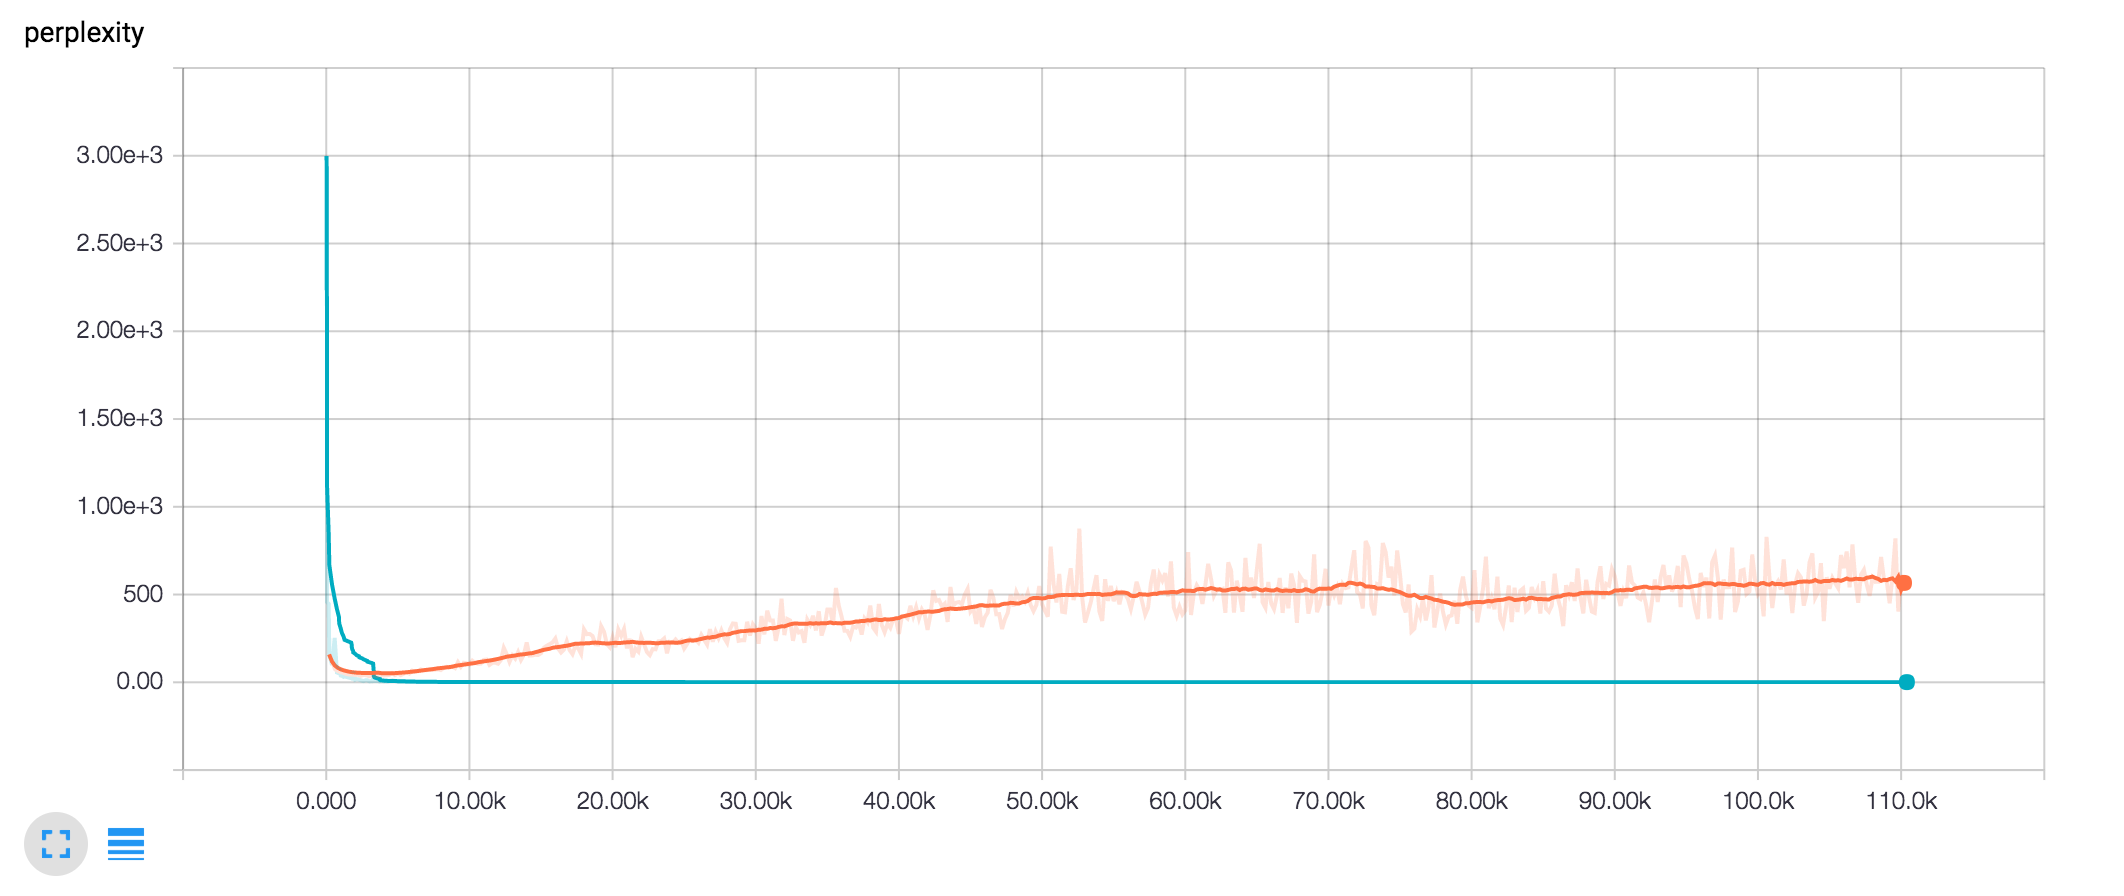

In [3]:
Image(filename='first-test-perplexity.png')

#### Test data set evaluation:

I ran the evaluation routine I wrote on the test data set of 500 sentence pairs, and got the following results:

- Average BLEU score: 0.57
- Average perplexity: 98433.95

#### Test data set translation examples

I used the "decode" routine to view the actual translations my model produces. Here are a few examples from the test data set:

- input: 君 は １ 日 で それ が でき ま す か 。
- expected: can you do it in one day ?
- model: will you come it or ?


- input: 僕 は これ から 彼 に 重大 な 申し出 を する つもり で す 。
- expected: i am going to make him a serious offer .
- model: i'm going to put him next .


- input: 今日 は 大変 暑 い 。
- expected: it is very hot today .
- model: it is very hot today .

The last sentence is the only correct translation. The other ones are nonsense. This matches the results of the validation data set evaluation: the short sentence was the only one the model did well on.

Since the perplexity graph suggests overfitting, that implies the model may have simply memorized the training examples. We can test that idea by giving the trained model training set inputs:

- input: ステーキ は 中位 で 焼 い て くださ い 。
- expected: i like my steak medium .
- model: i like my steak medium and i like them .


- input: 彼女 の 美し さ に 関 し て は 、 疑 う 余地 が な い 。
- expected: there is no doubt as to her beauty .
- model: there is no doubt as to her beauty .


- input: 相撲 を 見 た こと が あ り ま す か 。
- expected: have you ever watched sumo wrestling ?
- model: have you ever watched sumo wrestling ?

The translations for training set data are nearly perfect, lending credence to the idea that the model has memorized the training examples instead of learning how to translate between two languages.

### Problem 2: Second test

I tried a slightly different version of the encoder-decoder model for my next experiment. I increased the number of layers from 1 to 3, and increased the cell size from 512 to 1024.

The results were even worse than the first model. The more complex model trained much more slowly, completing only 62,200 batches in 15 hours, compared to the first model's 114,400 batches.

The graph of average training and validation perplexity is shown below. The patten is the same as before, but the overfitting is much worse, with the validation perplexity reaching around 2000 by the end. Note that the upwards swing in the validation set perplexity at the very end is simply an artifact of the smoothing algorithm used by Tensorboard.

Broken down by bucket, the final validation perplexities are:

- bucket 0 perplexity 255.29
- bucket 1 perplexity 1865.86
- bucket 2 perplexity 5386.03
- bucket 3 perplexity 23535.34

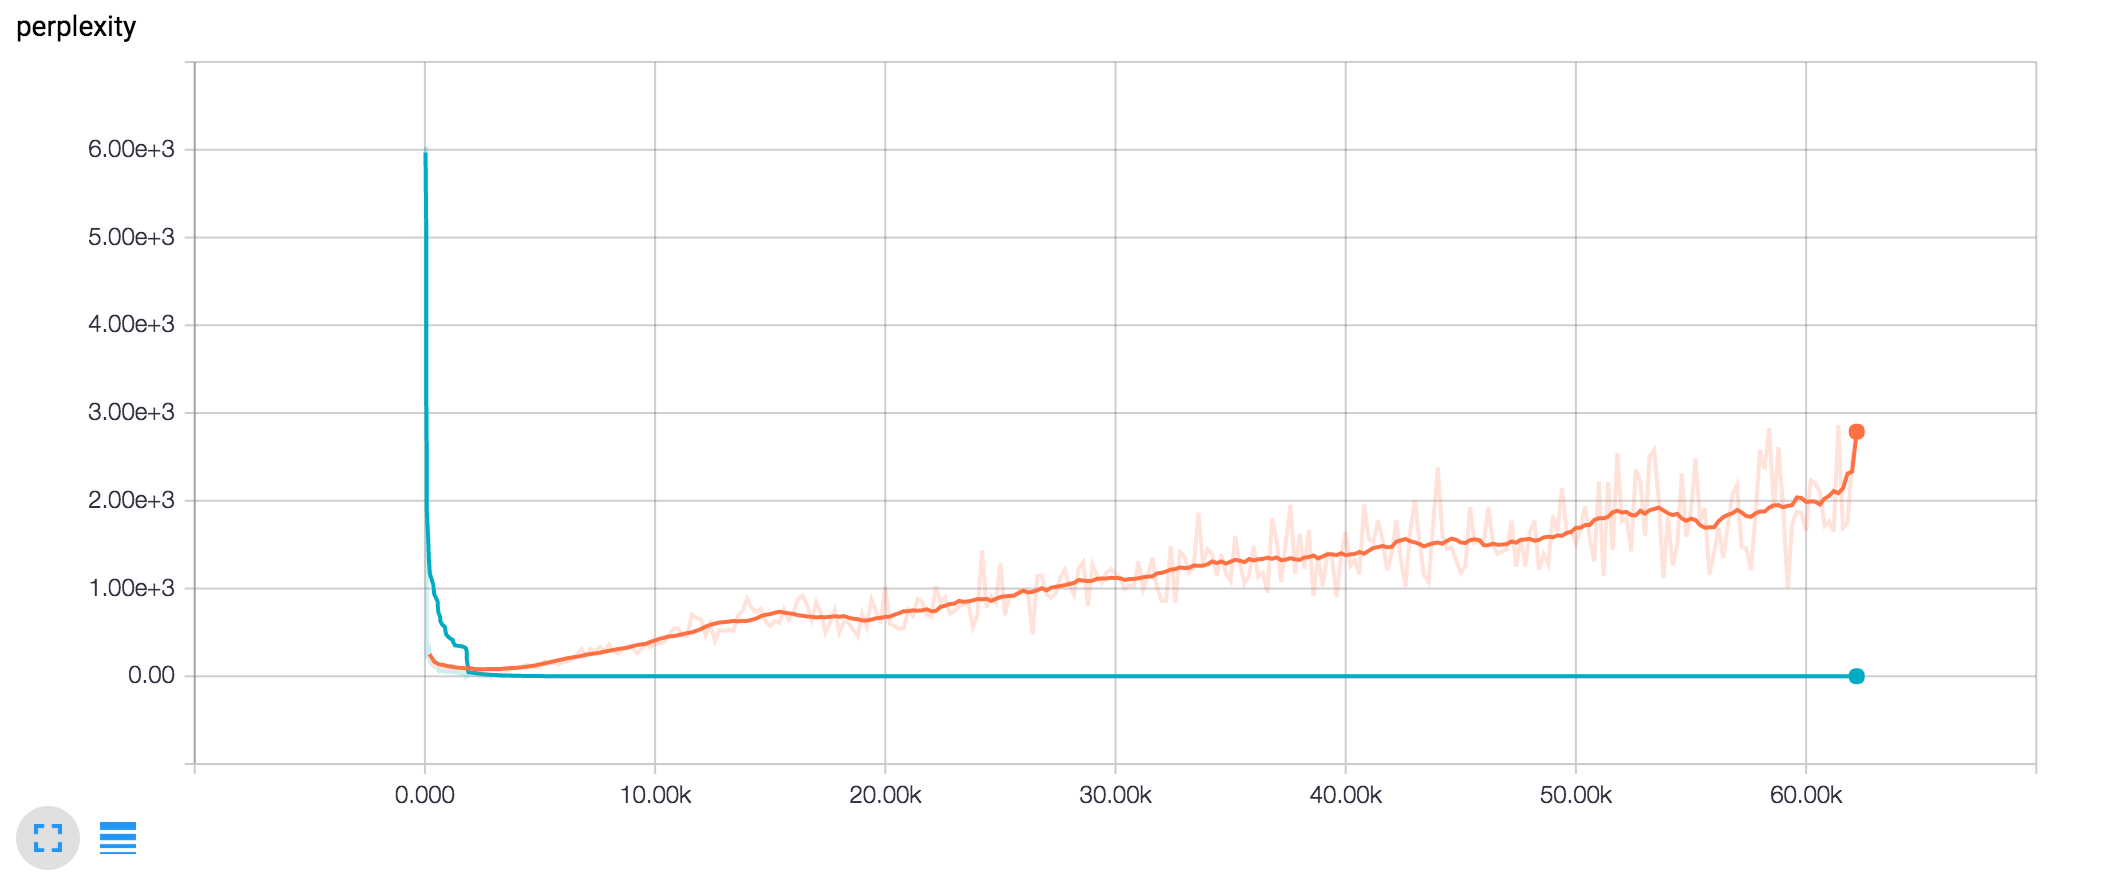

In [5]:
Image(filename='no-attention-perplexity.png')

#### Test data set evaluation:

The BLEU score on the test data set is 0.01 larger than before, but I like that is likely due to chance, since the test set perplexity is huge:

- Average BLEU score 0.58
- Average perplexity 57840.07

#### Translation Examples

The translations are slighly worse than those of the previous model:

- input: 君 は １ 日 で それ が でき ま す か 。
- expected: can you do it in one day ?
- model: do you see a day at ?


- input: 僕 は これ から 彼 に 重大 な 申し出 を する つもり で す 。
- expected: i am going to make him a serious offer .
- model: i am him him mistake this out out him .


- input: 今日 は 大変 暑 い 。
- expected: it is very hot today .
- model: it's today today .

## Problem 3: Attention model

seq2seq_model.py uses Tensorflow's [embedding_attention_seq2seq](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/seq2seq.py#L753) model by default, so using it was easy. This model gives each input and output a word embedding vector, and uses a soft-attention model.

### Problem 3: First Attention Model Test

I tried to train it initially with a cell size of 2014, but the HPC clusters could not fit it in memory. Instead, I reduced the size to 512. I used 3 layers of GRU. The only difference between this model and the previous one is my use of GRU.

Its results are even worse than the previous two models. The average validation perplexity reaches 10000 towards the end. Again, the sharp drop at the end is just an artifact of how Tensorboard smoothes the graph.

- bucket 0 perplexity 8565.54
- bucket 1 perplexity 96915.81
- bucket 2 perplexity 30089.07
- bucket 3 perplexity 1735731.58

#### Test data set evaluation

- Average BLEU score 0.58
- Average perplexity 857715655.65 (!!!)

The translations examples are totally nonsensical, so I won't even print them.

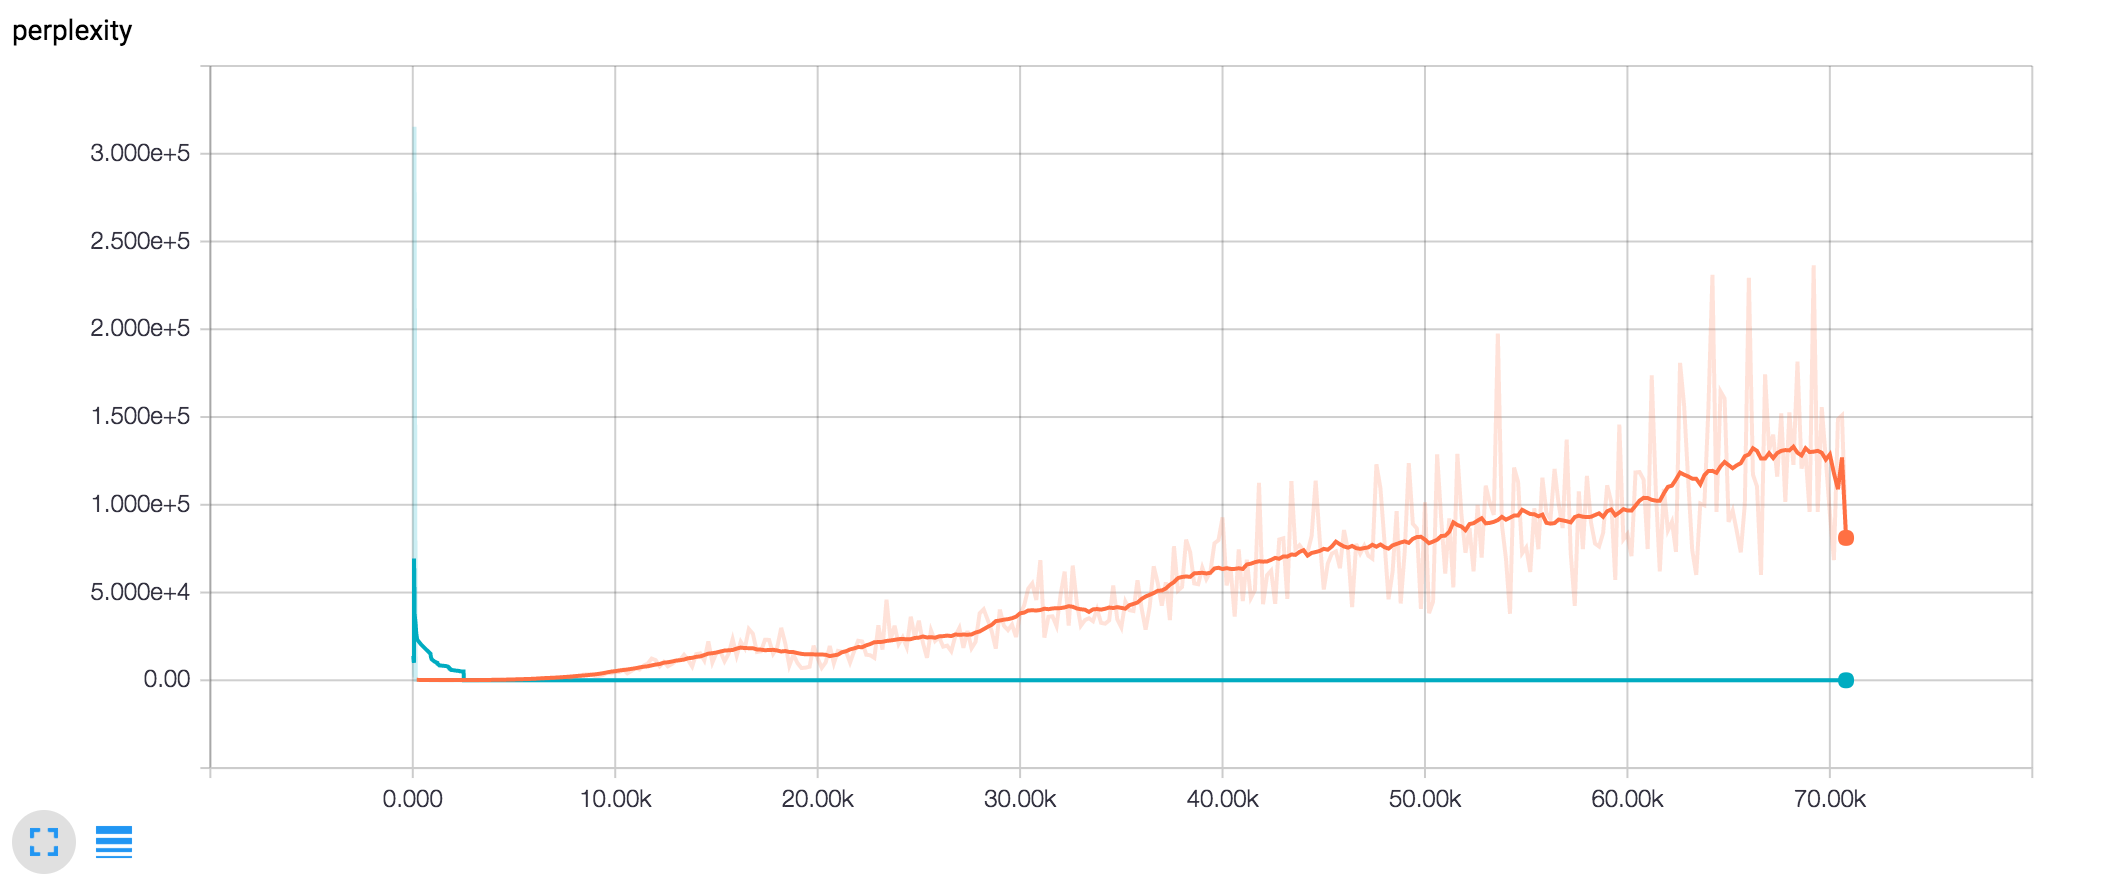

In [7]:
Image(filename='attention1-perplexity.png')

### Problem 3: Attention Model 2

--use_attention=true --num_layers=1 --size=256



TODO save/attention2

Using an early version of the model from step 1000.

test set eval: average perplexity 2877.33
test set eval: average bleu score 0.54
Number of inputs whose translation didn't have EOS: 18

Reading model parameters from /scratch/akp258/nlp/hw4/save/attention2/translate.ckpt-2000


### Problem 3: ADAM Optimizer
TODO